In [367]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


<br>

## 데이터 준비

<br>

In [368]:
# tf.keras 안에 있는 datasets에서 cifar10 데이터 읽어오기
# _ 변수는 데이터 무시

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [369]:
# 32x32 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [370]:
# 각 픽셀을 -1 ~ 1 로 정규화

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [371]:
# 데이터셋 shape 확인

train_x.shape

(50000, 32, 32, 3)

In [372]:
# Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1
# 따라서 데이터셋의 shape 마지막에 1을 추가

train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


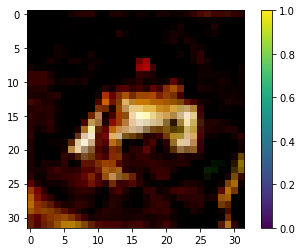

In [373]:
# 첫 번째, 데이터 확인

plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

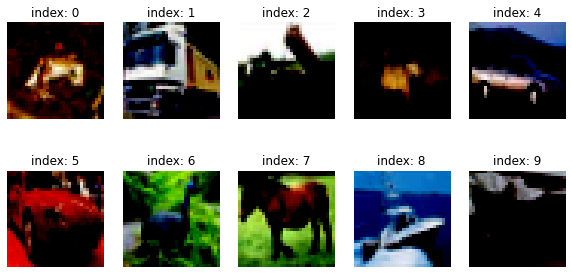

In [374]:
# 열 개 데이터 확인

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

<br>

### 학습을 위한 텐서플로우 Dataset 준비 <br><br>

__BUFFER_SIZE__ 는 전체 데이터를 섞기 위해 60,000으로 설정 <br>
- shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줍니다 <br><br>

__BATCH_SIZE__ 는 모델이 한 번에 학습할 데이터의 양 (미니배치 학습) <br>
- 너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적 <br>
- 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행 <br><br>

tf.data.Dataset 모듈의 __from_tensor_slices()__ 함수를 사용 <br>
- 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋 생성 <br>
- .shuffle(버퍼사이즈) 메서드와 .batch(배치사이즈) 메서드 사용 가능

<br>

In [375]:
# Dataset 파라미터
"""
256 -> 128 로 변경
"""

BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [376]:
# tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋 생성

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<br>

## DCGAN 생성자 모델 구현

Keras Sequential API를 활용하여 모델 구현 <br>
- tf.keras.Sequential()로 모델을 시작 <br>
- DCGAN 모델을 위한 레이어 구성 <br>
- Conv2-Transpose 레이어가 핵심 <br>
( Conv2D와 반대로 이미지 사이즈 넓혀줌 ) <br>
- BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화 <br>
- 중간층들의 활성화 함수는 모두 LeakyReLU를 사용 <br>
- 마지막 층에는 활성화 함수로 tanh를 사용 <br>
( -1 ~ 1 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함 ) <br><br>

참고. <br>
[Tensorflow 2.0 Tutorial 의 DCGAN 구현](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)

<br>

In [377]:
# 언제든 생성자를 생성할 수 있도록 make_generator_model 함수 작성
"""
Dense layer 와 Reshape Layer 데이터 크기 조정 (입력 데이터에 맞게 7 -> 4)
출력되는 마지막 레이어 데이터 채널수에 맞게 1 -> 3 으로 조정
Conv2DTranspose layer 개수 늘려서 깊이 증가
Conv2DTranspose layer 파라미터 조정 : 
kernel_size (5, 5) -> (4, 4)
strides (1, 1) -> (2, 2)
LeakyReLU 의 alpha=0.2
마지막 Layer Conv2DTranspose 에서 Conv2D로 변경
"""

def make_generator_model():

    # Start: tf.keras.Sequential()로 모델을 시작
    model = tf.keras.Sequential()

    # First: Dense layer
    # 입력 데이터 크기를 정수로 나눌 수 있는 사이즈로 (?)
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Sixth: Conv2DTranspose layer
    # color channel 이 RGB 이므로 3 으로 설정
    model.add(layers.Conv2D(3, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [378]:
# 생성 모델을 generator라는 변수로 생성
# summary 로 모델 세부내용 확인

generator = make_generator_model()

generator.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_99 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 8, 8, 256)         1638400   
_________________________________________________________________
batch_normalization_100 (Bat (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 8, 8, 256)       

<br>

### 학습되지 않은 모델 작동 확인 <br><br>

shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성한 뒤, <br>
이를 입력으로 하여 위에서 구현한 학습되지 않은 모델이 기대하는 형태의 출력값을 생성하는지 확인해 봅시다. <br>
- tf.random.normal을 이용 <br>
가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성 가능<br><br>


#### 모델 사용 <br>
텐서플로우 2.0 버전에서는 레이어와 모델에 call 메소드를 구현해 놓음 <br>
구현한 모델에 입력값을 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성 <br>
( 내부적으로는 모델의 call 함수가 호출됨 ) <br><br>

- 학습하는 중이 아니니 training=False를 설정해 주어야 합니다! <br>
( Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다름 )

<br>



<br>

In [379]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.

noise = tf.random.normal([1, 100])

In [380]:
# 학습되지 않은 모델을 이용하여 결과 확인

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

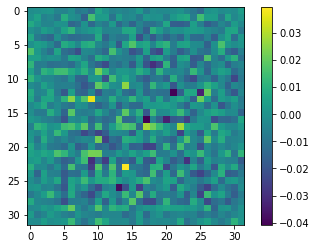

In [381]:
# 이미지 plot 하여 결과 확인
# -1 ~ 1 사이의 학습되지 않은 노이즈가 출력됩니다.

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

<br>

## DCGAN 판별자 모델 구현

가짜 이미지와 진짜 이미지를 입력받으면 <br>
각 이미지 별로 '진짜라고 판단하는 정도'값을 출력 <br><br>

Keras Sequential API를 활용하여 모델 구현 <br>

- tf.keras.Sequential()로 모델을 시작 <br>
- DCGAN 모델을 위한 레이어 구성 <br>
- Conv2D 레이어가 핵심 <br>
( Conv2DTranspose와 반대로 이미지 사이즈 줄여줌 ) <br>
- 중간층들의 활성화 함수는 모두 LeakyReLU를 사용 <br>
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 쭉 펴서 1차원 형상의 벡터로 변환 <br>
( 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할 ) <br>
- 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력 <br><br>

참고. <br>
[Tensorflow 2.0 Tutorial 의 DCGAN 구현](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)

<br>

In [382]:
# 언제든 판별자를 생성할 수 있도록 make_discriminator_model 함수 작성
"""
Dense layer 와 Reshape Layer 데이터 크기 조정 (입력 데이터에 맞게)
Conv2DTranspose layer 개수 늘려서 깊이 증가
Conv2DTranspose layer 파라미터 조정 : 
kernel_size (5, 5) -> (3, 3)
strides (2, 2)
LeakyReLU 의 alpha=0.2
Dropout 제거
Flatten Layer 에만 Dropout(0.3) 추가
Dense Layer 의 activation='sigmoid'
"""

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # third: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sixth: Dense Layer
    model.add(layers.Dense(1024))
    model.add(layers.Dense(512, activation='tanh'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [383]:
# 생성 모델을 discriminator라는 변수로 생성
# summary 로 모델 세부내용 확인

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_103 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_104 (Bat (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_104 (LeakyReLU)  (None, 8, 8, 128)       

In [384]:
# 위에서 generator 모델로 생성한 가짜 이미지를 discriminator 모델로 판별결과 출력해보기
# 텐서플로우의 텐서 형태로 출력됨

decision = discriminator(generated_image, training=True)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.19412753]], dtype=float32)>

<br>

## 손실함수 (Loss Function) <br><br>

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용 <br>
- 교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수 ) <br>
( 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 사용 ) <br>
- 이진 교차 엔트로피(binary cross entropy)를 사용 <br>
( 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로! )  <br><br>

정량적으로 달성해야 하는 목표 <br>
- 생성자 : 판별자가 Fake Image에 대해 판별한 값 <br>
( 즉 D(fake_image) 값이 1에 가까워지는 것 ) <br>
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값 <br>
( 즉 D(fake_image)는 0에 가까워지는 것 ) <br><br><br>



### 케라스 tf.keras.losses의 BinaryCrossEntropy <br><br>

교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있습니다. <br><br>

우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠. <br><br>

#### tf.keras.losses의 BinaryCrossEntropy 클래스 <br>
기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정 ([참고](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1)). <br>
따라서 __from_logits=True__로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 <br>
함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산

<br>

In [385]:
# 손실함수로 사용할 cross_entropy 생성

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

<br>

### generator_loss 구현 <br><br>

generator_loss는 fake_output가 1에 가까워지기를 목표 <br>
- 1로 채워진 벡터 (tf.ones_like) 와의 교차 엔트로피값을 계산 <br><br>

즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 <br>
fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 갑음

<br>

In [386]:
# generator_loss 구현

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

<br>

### discriminator_loss 구현 <br><br>

discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 목표 <br>
- 두 가지 loss값을 모두 계산 <br>
- real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교 <br><br>

최종 discriminator_loss 값은 이 둘을 더한 값

<br>

In [387]:
# discriminator_loss 구현

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

<br>

### discriminator_accuracy 구현 <br><br>


판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요 ! <br>
( 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용 ) <br><br>

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. <br>
- real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, <br>
- 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. <br>
- fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

<br>

In [388]:
# discriminator accuracy 구현

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

<br>

## 최적화 함수 (Optimizer) <br><br>

Adam 최적화 기법 을 활용 <br>
tf.keras.optimizers 안의 Adam 함수 사용 <br><br>

1. 하이퍼 파라미터 __learning rate__는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천 <br><br>

2. __생성자__와 __구분자__는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 함 !

참고. <br>
[신경망 학습 최적화](https://sacko.tistory.com/42)

<br>

In [389]:
# 생성자 optimizer 와 구분자 optimizer 따로 생성
"""
Adam optimizer 의 learning late 을 0.0001 에서 0.0002 로 수정. beta_1 을 0.5 할당.
"""

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

<br>

#### 생성자 생성 샘플 확인

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인 <br><br>

- 샘플은 한 번에 16장을 생성 <br>
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈 준비 <br>
( 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들기 )

<br>

In [390]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

<br>

## 훈련과정 설게

<br>

<br>

### train step 함수 생성 <br>

<br>

In [391]:
# train_step 함수 생성
# decorator 사용

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

<br>

### 학습과정 check : 결과물 샘플 이미지 plot 저장 <br><br>

- 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 생성 <br>
- 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인 <br><br>

학습된 모델에 의해 생성된 이미지를 저장하기 위해 작업환경 내에 generated_samples 디렉토리를 사용

<br>

In [392]:
# 학습 현황을 볼 수 있는 샘플을 생성하는 함수 작성
# 한 단계씩 학습할 train_step과 함께 일정 간격으로 샘플 생성

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

<br>

### 학습과정 check : loss와 accuracy 그래프 시각화 <br><br>

train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy  4가지 값을 <br>
history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수 생성 <br>
( 예를 들어 생성자의 loss의 history는 history'gen_loss'로 접근할 수 있는 list로 관리 ) <br><br>

생성자 모델과 판별자 모델의 loss와 acurracy를 저장하기 위해 작업환경 내에 trsining_history 디렉토리를 사용

<br>

In [393]:
# 학습과정 체크를 위한 loss 와 accuracy 그래프 시각화
# 매 epoch 마다 시각화 하는 함수 작성

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

<br>

### 학습과정 check : 정기적으로 모델을 저장

#### tf.train.Checkpoint를 활용 <br>
매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리 <br><br>

checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장 <br>
우리의 학습 환경과 학습한 내용을 저장 <br>
( 정확히는 생성자와 구분자가 __학습한 모델 가중치__를 저장 ) <br><br>

checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 디렉토리를 사용


<br>

In [394]:
# checkpoint 모델 저장
# 작업환경 내 training_checkpoints 디렉토리 사용

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<br>

## 모델 학습 <br><br>


한 단계를 학습하는 train_step, <br>
샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), <br>
학습 과정을 시각화하는 draw_train_history(), <br>
그리고 모델까지 저장하기 위한 checkpoint <br><br>

모두 준비가 되었으니 이것들을 한 곳에 합치기

<br>

In [395]:
# 모델 학습을 위한 함수 생성
# 앞에서 생성한 함수들 합치기

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

<br>

### 학습 파라미터 설정 <br><br>

save_every : 모델을 저장하는 간격을 담당 <br>
EPOCHS : 전체 학습 에포크를 결정

<br>

In [396]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<br>

### 학습 실행 <br><br>

우리가 생성된 샘플을 시각화하거나 원하는 시간을 출력. <br>
출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정해서 마음에 드는 형태로 확인해 보세요!

<br>

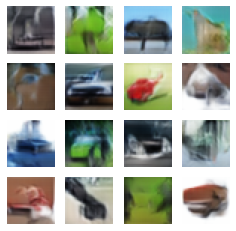

Time for training : 3387 sec


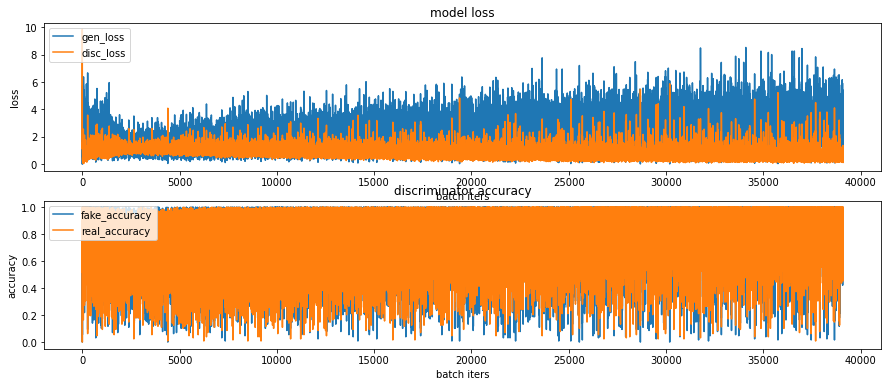

CPU times: user 17min 10s, sys: 29.1 s, total: 17min 40s
Wall time: 56min 30s


In [397]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

<br>

## 학습과정 시각화 <br>

imageio 라이브러리를 활용해 GIF 파일 생성

<br>

In [398]:
# 학습과정 시각화 gif 파일 생성

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-rw-r-- 1 ssac29 ssac29 2366906  2월 26 06:21 /home/ssac29/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


<br>

- dropout conv layer 에서 다 빼고, 마지막 flatten layer 에 하나만 추가해주니 loss 2 ~ 4 대에서 1.5 대로 떨어짐 <br>
- discriminator 에서 activation sigmoid 썼더니 초반 심정지
- batchnormalization 빼보기

<br>

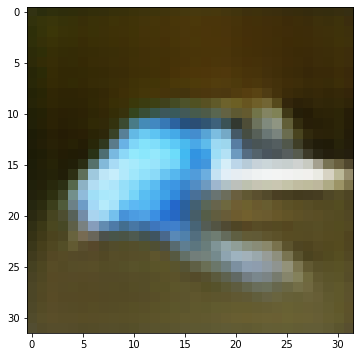

In [406]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


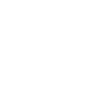

In [400]:


plt.figure(figsize=(10, 10)) 
for i in range(15): 
    noise = tf.random.normal([1, 100]) 
    generated_image = generator(noise, training=False) 
    np_generated = generated_image.numpy() 
    np_generated = (np_generated * 127.5) + 127.5 
    # reverse of normalization np_generated = np_generated.astype(int) 
plt.subplot(5, 5, i+1) 
plt.axis('off') 
plt.imshow(np_generated[0]) 
plt.show() 
# 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것이다

<br>

## 모델 개선 사항 <br><br>

1. __generater model 의 Conv2DTranspose layer 추가__ <br>
__discriminator model 의 Conv2D layer 추가__ <br>
모델의 깊이 증가로 각 모델의 loss 개선 <br><br>

2. __LeakyReLU 모델의 alpha=0.2 을 추가하여 모델 성능 개선__ <br>
__Adam optimizer 의 learning-rate 과 beta_1 옵션을 수정하여 학습률 개선__ <br><br>

3. __activation='sigmoid' 로 하는 Dense Layer 를 추가__ <br>
fake_accuracy 와 real_accuracy 개선

<br>